In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
import random

from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from scipy import special
import gym

Using TensorFlow backend.


# System Environment

In [2]:
import sys
print('python: ', sys.version)
import keras
print('keras: ', keras.__version__)
import tensorflow
print('tensorflow: ', tensorflow.__version__)
import scipy
print('scipy: ', scipy.__version__)
print('numpy: ', np.__version__)
print('gym: ', gym.__version__)

python:  3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
keras:  2.3.1
tensorflow:  2.0.0
scipy:  1.3.1
numpy:  1.17.2
gym:  0.15.4


# Seeds for reproducibility 

In [3]:
random.seed(42)
np.random.seed(42)
import tensorflow
tensorflow.random.set_seed(42)

# Replay Memory

In [4]:
class ReplayBuffer():
    def __init__(self, mem_size, input_dim):
        self.memory = deque(maxlen=mem_size)
        self.input_dim = input_dim
        
    def add(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
        
    def get_batch(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        
        # create the placeholders for the replay batch
        states = np.zeros((batch_size, self.input_dim), dtype=np.float32)
        actions = np.zeros(batch_size, dtype=np.int8)
        rewards = np.zeros(batch_size, dtype=np.float32)
        next_states = np.zeros((batch_size, self.input_dim), dtype=np.float32)
        dones = np.zeros(batch_size, dtype=np.int8)
        
        # fill the placeholders for the replay batch
        for i in range(len(batch)):
            states[i] = batch[i][0]
            actions[i] = batch[i][1]
            rewards[i] = batch[i][2]
            next_states[i] = batch[i][3]
            dones[i] = batch[i][4]
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)

# Model

In [5]:
def build_model(input_dim, output_dim, hidden1, hidden2, lr):
    model = Sequential()
    model.add(Dense(hidden1, activation='relu', input_dim=input_dim))
    model.add(Dense(hidden2, activation='relu'))
    model.add(Dense(output_dim))
    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model

# Agent

In [6]:
class Agent():
    def __init__(self, params, model_params):
        self.gamma = params['gamma']
        self.input_dim = params['input_dim']
        self.action_dim = params['action_dim']
        self.batch_size = params['batch_size']
        self.model_file = params['model_file']
        self.tau = params['tau']
        self.random_min = params['random_min'] / self.action_dim
        
        self.memory = ReplayBuffer(params['mem_size'], self.input_dim)
        
        self.model = build_model(self.input_dim, self.action_dim, 
                                 model_params['h1'], model_params['h2'], model_params['alpha'])
        
    def get_action(self, state):
        actions = self.model.predict([state])[0]
        
        # apply the softmax
        actions = special.softmax(actions / self.tau)
        
        # add some minimum random probability
        actions += self.random_min
        actions /= np.sum(actions)
        
        action = np.random.choice(self.action_dim, p=actions)
        return action
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # get the training data
        states, actions, rewards, next_states, dones = self.memory.get_batch(self.batch_size)
        
        # transform the models input to one-hot encoding
        actions_one_hot = np.zeros((self.batch_size, self.action_dim), dtype=np.int8)
        actions_one_hot[np.arange(self.batch_size), actions] = 1
        
        states = states.reshape(-1, self.input_dim)
        next_states = next_states.reshape(-1, self.input_dim)
        
        q_target = self.model.predict(states)
        q_next = self.model.predict(next_states)
        
        batch_index = np.arange(self.batch_size)
        q_target[batch_index, actions] = rewards + self.gamma * np.max(q_next, axis=1) * (1 - dones)
        
        self.model.fit(states, q_target, verbose=0)
        
    def save_model(self, run, episode):
        self.model.save(self.model_file + '_r' + str(run) + '_e' + str(episode)  + '.h5')   
        
    def load_model(self):
        self.model = load_model(self.model_file)

# Training the Agent

In [7]:
env = gym.make('LunarLander-v2')
env.seed(42)

runs = 5
episodes = 300

agent_params = {'input_dim': 8, 'action_dim': 4, 'gamma': 0.99, 
                'tau': 0.2, 'random_min': 0.01,
                'mem_size': 1000000, 'batch_size': 256, 'model_file':'models/SoftmaxLunarLander'}

model_params = {'h1': 256, 'h2': 128, 'alpha': 0.0001}

print(agent_params)
print(model_params)

scores = np.zeros((runs, episodes))

for run in range(1, runs+1):
    
    agent = Agent(agent_params, model_params)
    
    for episode in range(1, episodes+1):
        done = False
        score = 0
        state = env.reset()

        while done == False:
            action = agent.get_action([state])
            next_state, reward, done, _ = env.step(action)
            score += reward
            
            agent.memory.add(state, action, reward, next_state, done)
            
            state = next_state
            agent.replay()
            
        scores[run-1][episode-1] = score
            
        if episode % 10 == 0:
            print("Run: %3d" % run, "   Episode: %3d" % episode, "   Score: %.2f" % score)
        
        # save model weights in the first episode and every 10th episode
        if episode == 1 or episode % 10 == 0:
            agent.save_model(run, episode)

{'input_dim': 8, 'action_dim': 4, 'gamma': 0.99, 'tau': 0.2, 'random_min': 0.01, 'mem_size': 1000000, 'batch_size': 256, 'model_file': 'models/SoftmaxLunarLander'}
{'h1': 256, 'h2': 128, 'alpha': 0.0001}
Run:   1    Episode:  10    Score: -127.00
Run:   1    Episode:  20    Score: -40.74
Run:   1    Episode:  30    Score: 13.23
Run:   1    Episode:  40    Score: -76.97
Run:   1    Episode:  50    Score: -56.94
Run:   1    Episode:  60    Score: -10.69
Run:   1    Episode:  70    Score: -29.52
Run:   1    Episode:  80    Score: 12.71
Run:   1    Episode:  90    Score: -69.35
Run:   1    Episode: 100    Score: -20.29
Run:   1    Episode: 110    Score: 210.06
Run:   1    Episode: 120    Score: 259.42
Run:   1    Episode: 130    Score: 230.08
Run:   1    Episode: 140    Score: 308.53
Run:   1    Episode: 150    Score: 45.18
Run:   1    Episode: 160    Score: 268.07
Run:   1    Episode: 170    Score: 193.74
Run:   1    Episode: 180    Score: 266.70
Run:   1    Episode: 190    Score: 236.20


# Analyzing Agent Performance from multiple runs

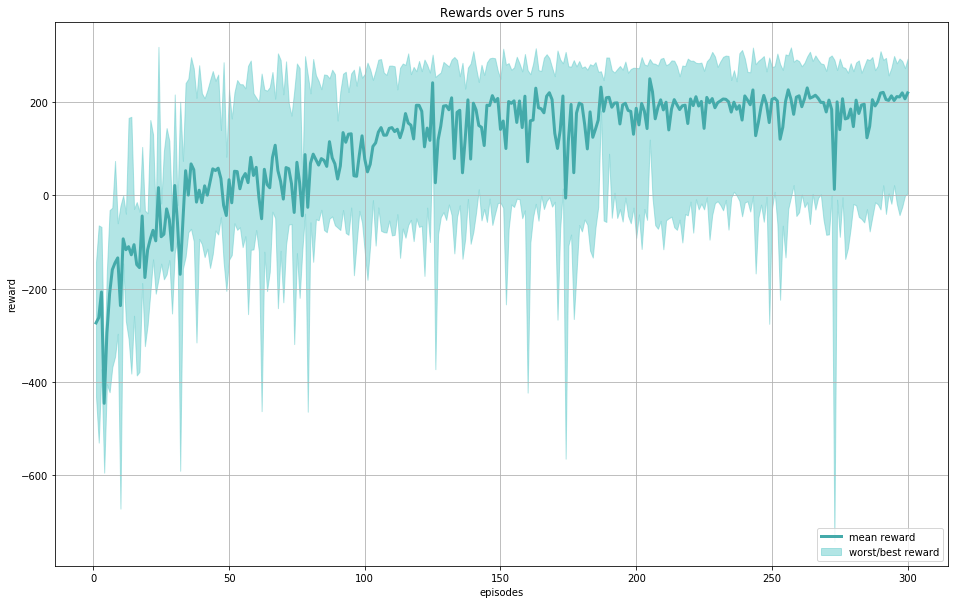

In [8]:
plt.figure(figsize=(16,10))
plt.fill_between(np.arange(1, episodes+1), scores.min(axis=0), 
                 scores.max(axis=0), color='#66CCCC', label='worst/best reward', alpha=0.5)
plt.plot(np.arange(1,episodes+1), scores.mean(axis=0), c='#44AAAA', linewidth=3, label='mean reward')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.grid()
plt.legend(loc='lower right')
plt.title('Rewards over ' + str(runs) + ' runs')
plt.show()

# Analyzing Agent Performances individualy

In [9]:
def movingAverage(signal, period):
    result = np.zeros_like(signal)
    for i in range(len(signal)):
        p = min(i+1, period)
        result[i] = signal[i-p+1:i+1].sum()/p
    return result

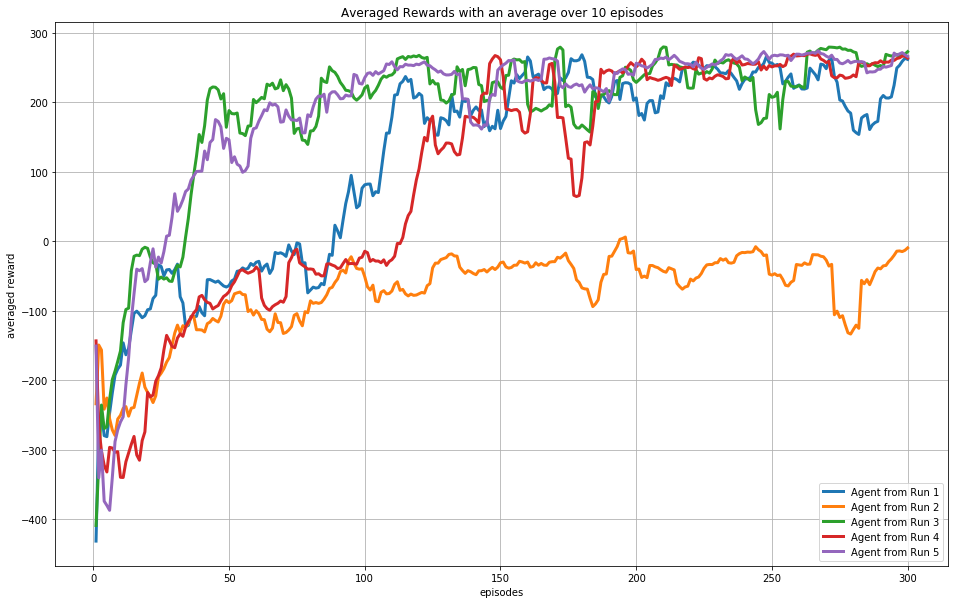

In [10]:
plt.figure(figsize=(16,10))
moving_average = 10

for run in range(1, runs+1):
    plt.plot(np.arange(1,episodes+1), movingAverage(scores[run-1], moving_average), linewidth=3, 
             label='Agent from Run ' + str(run))

plt.xlabel('episodes')
plt.ylabel('averaged reward')
plt.grid()
plt.legend(loc='lower right')
plt.title('Averaged Rewards with an average over ' + str(moving_average) + ' episodes')
plt.show()

# Watch the final agent from the last run with greedy policy 

In [11]:
env = gym.make('LunarLander-v2')

# change to greedy
tau = agent.tau
random_min = agent.random_min
agent.tau = 0.01
agent.random_min = 0.0

for i in range(5):
    state = env.reset()
    done = False
    while done == False:
        action = agent.get_action([state])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        env.render()
        
env.close()

# undo change to greedy
agent.tau = tau
agent.random_min = random_min 